In [109]:
# libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# parameters
interpolate = True
interpolate_factor = 10

# pre processing
df = pd.read_csv('global-plastics-production.csv')
df.columns = ['Entity', 'Code', 'Year', 'plastic-production']
df = df.set_index('Year')
df.sort_values(by='Year', inplace=True)
df.drop(['Entity', 'Code'], axis=1, inplace=True)

# add value for missing year 1974
df.loc[1974] = np.nan

# interpolation
if interpolate:
   multiple = interpolate_factor
   new_index = np.linspace(df.index.min(), df.index.max(), len(df) * multiple-(multiple-1))
   df = df.reindex(new_index).interpolate(method='polynomial', order=2)
   df.reset_index(inplace=True)
   df['Year'] = df['Year'].astype(int)
   df.index = df['Year']
   df.drop(columns='Year', inplace=True)
   df.index = new_index

round(df.tail(10))

,plastic-production
2018.1,443055072.0
2018.2,445025928.0
2018.3,446967707.0
2018.4,448880409.0
2018.5,450764035.0
2018.6,452618585.0
2018.7,454444059.0
2018.8,456240456.0
2018.9,458007776.0
2019.0,459746020.0


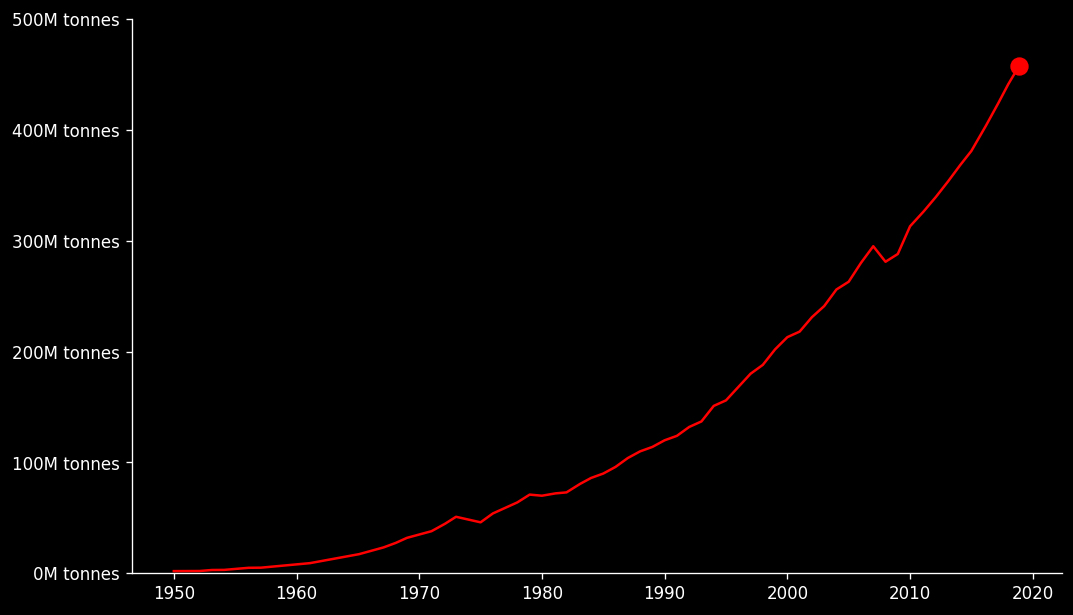

In [108]:
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation

# parameters
background_color = 'black'
text_color = 'white'

# Setting up the plot
fig, ax = plt.subplots(figsize=(10, 6), dpi=120)
fig.set_facecolor(background_color)
ax.set_facecolor(background_color)
ax.tick_params(axis='x', colors=text_color)
ax.tick_params(axis='y', colors=text_color)
ax.spines[['left', 'bottom']].set_color(text_color)

# Update function for the animation
def update(frame):

    # skip first frame
    if frame == 0:
        return None

    # initialize subset of data
    subset_df = df.iloc[:frame]
    ax.clear()

    # create the line chart
    line_color = 'red'
    ax.plot(subset_df.index, subset_df['plastic-production'], color=line_color)
    ax.scatter(subset_df.index[-1], subset_df['plastic-production'].values[-1], color=line_color, s=100)

    # custom axes
    y_min = df.iloc[:frame+1].sum(axis=1).min()
    y_max = df.iloc[:frame+1].sum(axis=1).max()
    ax.set_ylim(0, y_max)
    ax.set_yticks(ax.get_yticks())
    ax.set_yticklabels([f'{int(x)}M tonnes' for x in ax.get_yticks()/1e6])
    ax.spines[['top', 'right']].set_visible(False)

# create and save animation
ani = FuncAnimation(fig, update, frames=len(df))
ani.save('global-plastics-production.gif', writer='imagemagick', fps=15)